In [ ]:
# /content/drive/MyDrive/Диплом/emails.csv
# /content/drive/MyDrive/Диплом/GoogleNews-vectors-negative300.bin

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [1]:
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras._tf_keras.keras.preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

from keras.layers import Dense, LSTM, Flatten, Embedding
from keras.utils import to_categorical
from keras.backend import clear_session
import numpy as np
import pandas as pd
import multiprocessing
import seaborn as sns
import email
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [5]:
import matplotlib.pyplot as plt
import re
import string
import time
pd.set_option('display.max_rows', 50)
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Data cleaning and preprocessing

In [43]:
filename = "/content/drive/MyDrive/Диплом/GoogleNews-vectors-negative300.bin"

google_embeddings = KeyedVectors.load_word2vec_format(filename, binary=True)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Диплом/emails.csv")

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
print(df.loc[1]['message'])

In [ ]:
message = df.loc[1]['message']
e = email.message_from_string(message)

e.items()

In [ ]:
e.get('Date')

In [ ]:
# now we add those fields into our 'df' dataframe
def get_field(field, messages):
    column = []
    for message in messages:
        e = email.message_from_string(message)
        column.append(e.get(field))
    return column

In [ ]:
df['date'] = get_field("Date", df['message'])
df['subject'] = get_field("Subject", df['message'])
df['X-Folder'] = get_field("X-Folder", df['message'])
df['X-From'] = get_field("X-From", df['message'])
df['X-To'] = get_field("X-To", df['message'])
df.head(3)

In [ ]:
def body(messages):
    column = []
    for message in messages:
        e = email.message_from_string(message)
        column.append(e.get_payload())
    return column

df['body'] = body(df['message'])
df.head(3)

In [ ]:
def employee(file):
    column = []
    for string in file:
        column.append(string.split("/")[0])
    return column

df['employee'] = employee(df['file'])
df.head(3)

In [ ]:
print("number of folders: ", df.shape[0])
print("number of unique folders: ", df['X-Folder'].unique().shape[0])

In [ ]:
unique_emails = pd.DataFrame(df['X-Folder'].value_counts())
unique_emails.reset_index(inplace=True)


unique_emails.columns = ['folder_name', 'count']
# top 20 folders
unique_emails.iloc[:20,:]

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='count', y='folder_name', data=unique_emails.iloc[:20, :], palette="Blues_d")
plt.title("Top 20 folders")
plt.xlabel("Count")
plt.ylabel("Folder_Name")
plt.show()

In [ ]:
df.head()

In [ ]:
import datetime
from dateutil import parser

def change_type(dates):
    column = []

    for date in dates:
        column.append(parser.parse(date).strftime("%d-%m-%Y %H:%M:%S"))
    return column

df['date'] = change_type(df['date'])
df.head(2)

In [ ]:
def preprocess_folder(folders):
    column = []
    for folder in folders:
        if (folder is None or folder == ""):
            column.append(np.nan)
        else:
            column.append(folder.split("\\")[-1].lower())
    return column

df['X-Folder'] = preprocess_folder(df['X-Folder'])
df.head(2)

In [ ]:
print("Unique Foldes: ", len(df['X-Folder'].unique()))

# view some of them
df['X-Folder'].unique()[0:20]

In [ ]:
def replace_empty_with_nan(subject):
    column = []
    for val in subject:
        if (val == ""):
            column.append(np.nan)
        else:
            column.append(val)
    return column

In [ ]:
df['subject'] = replace_empty_with_nan(df['subject'])
df['X-To'] = replace_empty_with_nan(df['X-To'])

In [ ]:
df.isnull().sum()

In [ ]:
miss = df.isnull().sum()
miss = miss[miss>0]
miss = miss / df.shape[0]
miss

In [ ]:
# drop missing value rows
df.dropna(axis=0, inplace=True)

In [ ]:
cols_to_drop = ['file','message','date','X-From','X-To','employee']

In [ ]:
df.drop(cols_to_drop, axis=1, inplace=True)
df.head()

In [ ]:
df.to_csv("cleaned_data.csv", index=False)

#  Preprocessing

In [6]:
df = pd.read_csv("/content/drive/MyDrive/Диплом/cleaned_data.csv")

In [ ]:
df

,subject,X-Folder,body
0,Re:,'sent mail,Traveling to have a business meeting takes the...
1,Re: test,'sent mail,test successful. way to go!!!
2,Re: Hello,'sent mail,Let's shoot for Tuesday at 11:45.
3,Re: Hello,'sent mail,"Greg,\n\n How about either next Tuesday or Thu..."
4,Re: PRC review - phone calls,'sent mail,any morning between 10 and 11:30
...,...,...,...
489231,Trade with John Lavorato,sent items,This is a trade with OIL-SPEC-HEDGE-NG (John L...
489232,Gas Hedges,sent items,Some of my position is with the Alberta Term b...
489233,RE: CONFIDENTIAL,sent items,2\n\n -----Original Message-----\nFrom: \tDouc...
489234,Calgary Analyst/Associate,sent items,Analyst\t\t\t\t\tRank\n\nStephane Brodeur\t\t\...


In [7]:
def remove_folders(emails, n):
    # returns the number of folders containing more than 'n' number of emails
    email_count = dict(df['X-Folder'].value_counts())
    small_folders = [key for key, val in email_count.items() if val<=n]
    emails = df.loc[~df['X-Folder'].isin(small_folders)]
    return emails

In [9]:
n = 300
df = remove_folders(df, n)

In [10]:
print("Total folders: ", len(df['X-Folder'].unique()))
print("df.shape: ", df.shape)

Total folders:  40
df.shape:  (450882, 3)


In [11]:
df['X-Folder'].unique()

array(["'sent mail", 'all documents', 'deleted items',
       'discussion threads', 'inbox', 'notes inbox', 'sent items', 'sent',
       'personal', 'california', 'calendar', 'it', 'hr', 'resumes',
       'connect deletes', 'archives', 'junk file', 'ces', 'logistics',
       'tufco', 'wellhead', 'projects', 'online trading', 'management',
       'universities', 'untitled', 'attachments', 'esvl', 'ooc',
       'corporate', 'tw-commercial group', 'genco-jv_ipo', 'read',
       'iso_ pricecaps', 'junk', 'california issues',
       'deal discrepancies', 'e-mail bin', 'bill williams iii',
       'schedule crawler'], dtype=object)

In [12]:
folders = ['personal', 'california', 'it', 'hr', 'resumes', 'logistics',
           'wellhead', 'projects', 'management', 'universities', 'corporate']

In [13]:
df = df[df['X-Folder'].isin(folders)]
df

,subject,X-Folder,body
4778,Dell Order Confirmation,personal,"Dear JENNIFER S MEDCALF,\n\nThank you for your..."
4779,Brown bag thank you,personal,"Dear Jennifer,\n\nThank you for hosting a brow..."
4780,Dell online order,personal,>\n>\n> DELL & ENRON ClickAtHome ORDER CONFIRM...
4781,UPDATE - Attendees for brown bags (12/13-12/14),personal,"I just noticed I missed Jim, who was, of cours..."
4782,Confirmation for Order #3253472,personal,Hope you are doing well!\n\n------------------...
...,...,...,...
482360,Singles Debate,personal,Hey check these out dude. The Smashing Pumkins...
482361,yummy frappachino,personal,Hey let's go get coffee again that was really ...
482362,Re: No Java?,personal,You are cracking me up. Basically you are the ...
482363,Re: No Java?,personal,So what's the situation? You swamped? Under pr...


In [14]:
df['text'] = df['subject'] + " " + df['body']

In [15]:
# drop the columns 'subject' and 'body'
df.drop(['subject','body'], axis=1, inplace=True)

In [16]:
def preprocess(x):
    # lowercasing all the words
    x = x.lower()

    # remove extra new lines
    x = re.sub(r'\n+', ' ', x)

    # removing (replacing with empty spaces actually) all the punctuations
    x = re.sub("["+string.punctuation+"]", " ", x)

    # remove extra white spaces
    x = re.sub(r'\s+', ' ', x)

    return x

In [17]:
start = time.time()
df.loc[:,'text'] = df.loc[:, 'text'].map(preprocess)

# remove stopwords
df.loc[:, 'text'] = df.loc[:, 'text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
end = time.time()
print("Execution time (sec): ",(end - start))

Execution time (sec):  9.011458158493042


In [18]:
def label_encoder(data):
    class_le = LabelEncoder()
    # apply label encoder on the 'X-Folder' column
    y = class_le.fit_transform(data['X-Folder'])
    return y

In [19]:
y = label_encoder(df)
input_data = df['text']

In [20]:
start = time.time()
folders_dict = dict(df['X-Folder'].value_counts().sort_values()[50:70])
data = df[df['X-Folder'].isin(folders_dict.keys())]
end = time.time()
print("Execution time (sec): ",(end - start))

Execution time (sec):  0.002518892288208008


In [21]:
email_count = dict(df['X-Folder'].value_counts())
email_count_df = pd.DataFrame(data=email_count.items(), columns=['folder_name', 'count'])
email_count_df

,folder_name,count
0,personal,2485
1,logistics,1170
2,california,1014
3,management,799
4,resumes,599
5,projects,459
6,corporate,420
7,hr,389
8,universities,359
9,it,358


<ipython-input-22-e357c0456c17>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='folder_name', data=email_count_df, palette="Blues_d")


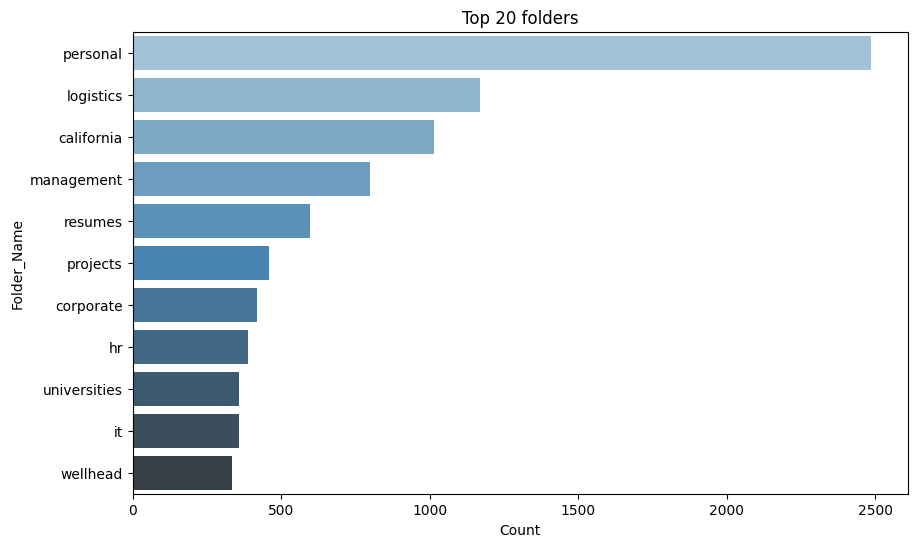

In [22]:
plt.figure(figsize=(10,6))
sns.barplot(x='count', y='folder_name', data=email_count_df, palette="Blues_d")
plt.title("Top 20 folders")
plt.xlabel("Count")
plt.ylabel("Folder_Name")
plt.show()

In [23]:
df.head()

,X-Folder,text
4778,personal,dell order confirmation dear jennifer medcalf ...
4779,personal,brown bag thank dear jennifer thank hosting br...
4780,personal,dell online order dell enron clickathome order...
4781,personal,update attendees brown bags 12 13 12 14 notice...
4782,personal,confirmation order 3253472 hope well forwarded...


In [24]:
df.to_csv("preprocessed_data.csv", index=False)

# Learning

In [46]:
data = pd.read_csv("preprocessed_data.csv")

In [47]:
data.head()

,X-Folder,text
0,personal,dell order confirmation dear jennifer medcalf ...
1,personal,brown bag thank dear jennifer thank hosting br...
2,personal,dell online order dell enron clickathome order...
3,personal,update attendees brown bags 12 13 12 14 notice...
4,personal,confirmation order 3253472 hope well forwarded...


In [48]:
# shape of the data
data.shape

(8387, 2)

In [53]:
# count number of instances in each folder
folders_num = len(data['X-Folder'].unique())

In [49]:
def label_encoder(data):
    class_le = LabelEncoder()
    # apply label encoder on the 'X-Folder' column
    y = class_le.fit_transform(data['X-Folder'])
    return y

In [50]:
y = label_encoder(data)
input_data = data['text']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(input_data, y, test_size=0.1)

In [54]:
# one-hot encode the output labels
Y_train = to_categorical(y_train, folders_num)
Y_test = to_categorical(y_test, folders_num)

In [55]:
# prepare tokenizer
t = Tokenizer()

# fit the tokenizer on the docs
t.fit_on_texts(input_data)
vocab_size = len(t.word_index) + 1

# integer encode the documents
X_train_encoded_docs = t.texts_to_sequences(X_train)
X_test_encoded_docs = t.texts_to_sequences(X_test)

In [56]:
max_length = 150
X_train_padded_docs = pad_sequences(X_train_encoded_docs, maxlen=max_length, padding='post')
X_test_padded_docs = pad_sequences(X_test_encoded_docs, maxlen=max_length, padding='post')

print(X_train_padded_docs[0])

[  760   176 16011  2364  1827    85   112   317  2517  1645 10039   109
   105     6   517    20   133   342   226    85   213    20   497   146
  1249   165   755  2195   898   732 16673  9829   953    85   147   167
 33857   645   493   341  3828   121   331  8350    85    32  6705  4106
  3411  2441 17229   314   733    66   322  1212   317  4700  5150    85
 10401   418    72  7038    85 16519   986   405   105     6   965    32
  1509   124  2806    48    32  1509   483  5995 33858   694  2364   105
     6  2806  1963   407  2463   169  1645   342 12367   169   418    72
  9978  1873  1068    59 14269  1229  1297  4122  1815   232  2654  1941
  2806    37  1381   120   322   501  4344  2902  4700   347   464    15
   132    85  6593   138    25    20   257   579  4700   202  2902  6933
  1262    10   515   472 12309  1873  1068  4700  7104   730    99  1620
  2028   417  1604  1943 13410  4010]


In [57]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in t.word_index.items():

    try:
        embedding_vector = google_embeddings[word]

        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except:
        pass

In [60]:
# define the model
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(LSTM(100, dropout=0.2))
model.add(Flatten())
model.add(Dense(folders_num, activation='softmax'))


# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 300)          17445600  
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 11)                1111      
                                                                 
Total params: 17607111 (67.17 MB)
Trainable params: 161511 (630.90 KB)
Non-trainable params: 17445600 (66.55 MB)
_________________________________________________________________


In [ ]:
# train the model
clear_session()
history = model.fit(X_train_padded_docs, Y_train, epochs=60, verbose=1, validation_split=0.1)

Epoch 1/60
213/213 [==============================] - 52s 230ms/step - loss: 2.1055 - accuracy: 0.3270 - val_loss: 1.9859 - val_accuracy: 0.3576
Epoch 2/60
149/213 [===================>..........] - ETA: 14s - loss: 2.0208 - accuracy: 0.3442